In [1]:
import pandas as pd
import random
import numpy as np
import scipy
import scipy.optimize as sco
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers


Reading data

In [2]:
DJSIreturns = pd.read_csv("DJSIreturnsexpanded.csv").dropna(axis = 0)
DJSIquants = np.array(np.array(DJSIreturns)[:,1:], dtype = "float")
treasurybond = pd.read_csv("HistoricalPrices.csv")
treasuryreturn = np.array(treasurybond)[2528, 4] - np.array(treasurybond)[0, 4]
inflationrate = 1.3
riskfreerate = treasuryreturn - inflationrate
mean_returns = np.mean(DJSIquants, axis=1)
covariance_returns = np.cov(DJSIquants)
print(DJSIreturns)

   Portfolio 2  10/1/2011  10/31/2011  11/30/2011  12/30/2011  1/29/2012  \
0          JLL  -0.277530    0.373725   -0.003095   -0.049053   0.220535   
2          MDT  -0.087543    0.092797    0.048647    0.049959   0.015686   
3         NDAQ  -0.036285    0.122815    0.047904   -0.066286   0.032232   
4          ETR  -0.005852    0.071406    0.017204    0.038232  -0.035866   
6           WY  -0.138418    0.179016   -0.066185    0.111971   0.087306   
..         ...        ...         ...         ...         ...        ...   
63          GS  -0.196862    0.216141   -0.124966   -0.056645   0.213425   
64         STT  -0.127011    0.329493   -0.018321    0.016646  -0.036715   
66          BK  -0.141057    0.200903   -0.085526    0.023124   0.005525   
67         PLD  -0.174690    0.315068   -0.065188    0.027678   0.105282   
68         ACN  -0.024197    0.167377   -0.038666   -0.081132   0.071952   

    2/28/2012  3/29/2012  4/28/2012  5/23/2012  ...  12/28/2020  1/27/2021  \
0    0.07

In [3]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) 
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def generate_random_weights(number, integer):
    randlist = np.array([np.exp(np.random.randint(0, integer)) for _ in range(number)]) 
    return randlist/np.sum(randlist)
        

print(portfolio_annualised_performance(generate_random_weights(np.shape(DJSIquants)[0], 10), np.mean(DJSIquants, axis=1), np.cov(DJSIquants)))
print(generate_random_weights(np.shape(DJSIquants)[0], 10))


(0.05449495519920628, 0.013361070509059854)
[3.51999677e-03 4.76379759e-04 6.44709896e-05 4.76379759e-04
 7.07010250e-02 8.72519964e-06 4.76379759e-04 3.51999677e-03
 7.07010250e-02 7.07010250e-02 1.29493444e-03 1.29493444e-03
 1.29493444e-03 6.44709896e-05 9.56834324e-03 9.56834324e-03
 7.07010250e-02 1.75250320e-04 1.29493444e-03 4.76379759e-04
 7.07010250e-02 1.75250320e-04 1.29493444e-03 6.44709896e-05
 9.56834324e-03 1.29493444e-03 2.60094536e-02 3.51999677e-03
 9.56834324e-03 1.29493444e-03 7.07010250e-02 1.29493444e-03
 9.56834324e-03 6.44709896e-05 2.60094536e-02 1.29493444e-03
 2.60094536e-02 1.29493444e-03 6.44709896e-05 1.75250320e-04
 7.07010250e-02 1.75250320e-04 4.76379759e-04 7.07010250e-02
 2.60094536e-02 2.37175516e-05 3.51999677e-03 4.76379759e-04
 1.75250320e-04 9.56834324e-03 7.07010250e-02 2.60094536e-02
 1.29493444e-03 4.76379759e-04 8.72519964e-06 4.76379759e-04
 7.07010250e-02 7.07010250e-02 6.44709896e-05 2.37175516e-05
 1.29493444e-03 6.44709896e-05 8.72519964

In [4]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

print(portfolio_volatility(generate_random_weights(np.shape(DJSIquants)[0], 10), np.mean(DJSIquants, axis=1), np.cov(DJSIquants)))

0.041956765136466415


In [5]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

efficient = efficient_return(np.mean(DJSIquants, axis=1), np.cov(DJSIquants), 0.01)

print(np.dot(efficient.x, np.mean(DJSIquants, axis=1)))
print(np.sqrt(np.matmul(np.matmul(efficient.x.T, np.cov(DJSIquants)), efficient.x)))

print(efficient.x)

0.009999999999823593
0.027580071607631505
[1.16223917e-17 2.56798363e-18 4.27795035e-02 0.00000000e+00
 0.00000000e+00 1.66593651e-19 3.75525008e-17 0.00000000e+00
 0.00000000e+00 7.06632354e-03 2.38409990e-03 9.87295435e-20
 3.13869185e-18 1.61731228e-02 2.06725720e-01 0.00000000e+00
 2.94581205e-18 2.18693096e-18 0.00000000e+00 1.31343335e-18
 1.77451730e-01 0.00000000e+00 8.17569931e-02 1.15494211e-17
 9.16365170e-02 5.85871838e-02 3.57341176e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.55477346e-18
 0.00000000e+00 0.00000000e+00 9.23580179e-03 1.33176623e-03
 1.50331131e-17 1.11089828e-01 0.00000000e+00 0.00000000e+00
 3.08714657e-02 2.69968060e-18 2.06262716e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.90574405e-18
 0.00000000e+00 3.22367079e-18 1.55932090e-17 0.00000000e+00
 0.00000000e+00 9.23580539e-03 1.33176731e-03 0.00000000e+00
 1.11089829e-01 8.14568461e-19 0.00000000e+00 2.09298078e-18
 2.06262709e-02 1.31260053e-18 0.00000000e+

In [6]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

efficients = efficient_frontier(np.mean(DJSIquants, axis=1), np.cov(DJSIquants), np.linspace(0, 0.022, 50))

In [7]:
efficient_sharpe_ratios = []

for eff in efficients:
    returns = np.dot(mean_returns, eff.x)
    risks = np.sqrt(np.matmul(np.matmul(eff.x, covariance_returns),eff.x.T))
    sharperatio = (returns-riskfreerate/100)/risks
    efficient_sharpe_ratios.append(sharperatio)


index_max_sharpe = efficient_sharpe_ratios.index(max(efficient_sharpe_ratios))

In [8]:
random_weights = []
for _ in range(1000):
    for n in range(2, 50):
        random_weights.append(generate_random_weights(np.shape(DJSIquants)[0], n))
                                           

random_weights = np.array(random_weights)
mean_returns = np.mean(DJSIquants, axis = 1)
covariance_returns = np.cov(DJSIquants) 

expected_returns = [np.dot(mean_returns, random_weights[i]) for i in range(np.shape(random_weights)[0])]
rand_risks = [np.sqrt(np.matmul(np.matmul(random_weights[i], covariance_returns),random_weights[i].T)) for i in range(np.shape(random_weights)[0])] 
sharpe_ratio = [(expected_returns[i] - riskfreerate/100)/rand_risks[i] for i in range(np.shape(random_weights)[0])]



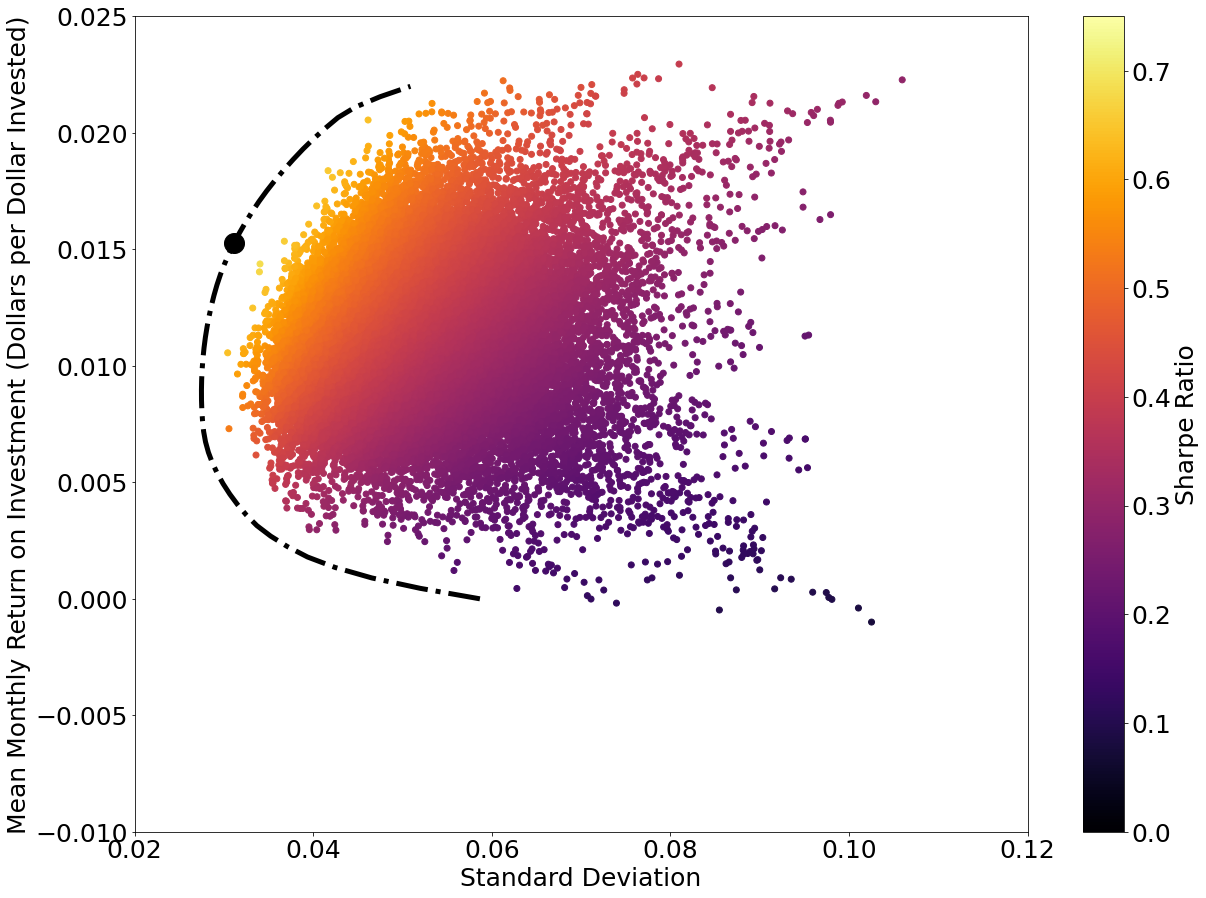

In [13]:
plt.figure(figsize = (20, 15))
plt.scatter(rand_risks, expected_returns, c = sharpe_ratio, cmap = 'inferno', marker= 'o')
plt.plot([p['fun'] for p in efficients], np.linspace(0, 0.022, 50), linestyle='-.', linewidth = 5, color='black', label='efficient frontier')
plt.plot(np.sqrt(np.matmul(np.matmul(efficients[index_max_sharpe].x, covariance_returns),efficients[index_max_sharpe].x.T)), np.dot(mean_returns, efficients[index_max_sharpe].x),
        marker = 'o', color = 'black', markersize = 20)
plt.xlim(0.02, .12)
plt.ylim(-.01,.025)
plt.clim(0,0.75)
plt.xlabel("Standard Deviation")
plt.ylabel("Mean Monthly Return on Investment (Dollars per Dollar Invested)")
plt.colorbar(label = "Sharpe Ratio")
plt.rc('font', size = 25)
plt.savefig("DJSIwsharpe.png", dpi = 600)
plt.show()

In [14]:
print(efficients[index_max_sharpe].x)


[0.00000000e+00 0.00000000e+00 1.44734936e-01 0.00000000e+00
 4.64377563e-17 5.77355620e-18 2.25056110e-18 0.00000000e+00
 1.09189360e-17 9.40999251e-02 6.41890685e-18 1.33783353e-17
 6.62709360e-18 4.03225923e-02 6.55125318e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.67783296e-18 3.56975840e-19
 2.11316638e-01 0.00000000e+00 6.44773923e-18 0.00000000e+00
 2.19806097e-01 8.39177154e-03 9.92630798e-18 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.10598824e-18 0.00000000e+00
 9.38183594e-04 0.00000000e+00 0.00000000e+00 2.68447540e-02
 0.00000000e+00 8.01248201e-02 0.00000000e+00 7.43849199e-19
 4.07025352e-18 0.00000000e+00 1.38354803e-18 0.00000000e+00
 1.40469846e-18 5.41597879e-18 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.24761693e-17 0.00000000e+00 9.38183132e-04
 0.00000000e+00 0.00000000e+00 2.68447490e-02 2.49221565e-17
 8.01248176e-02 0.00000000e+00 3.02630446e-18 1.29973234e-17
 1.17539912e-17 0.00000000e+00 0.00000000e+00]


In [15]:
np.savetxt("optimal_DJSIweights.csv", efficients[index_max_sharpe].x, delimiter=",")

In [16]:
print(np.sqrt(np.matmul(np.matmul(efficients[index_max_sharpe].x, covariance_returns),efficients[index_max_sharpe].x.T))*np.sqrt(12))
print(np.dot(mean_returns, efficients[index_max_sharpe].x)*12)
print(max(efficient_sharpe_ratios))

0.10782247289685723
0.18318367346786396
0.7779851342273917
